# Model training and prediction - `s30d`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

In [5]:
X_train = pd.read_csv("./data/processed/s30d/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/s30d/y_train.csv", index_col = 0).s30d
X_test = pd.read_csv("./data/processed/s30d/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/s30d/y_test.csv", index_col = 0).s30d

In [6]:
y_train.value_counts() / len(y_train.index) * 100

0.0    94.197074
1.0     5.802926
Name: s30d, dtype: float64

In [7]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## LightGBM

In [8]:
from lightgbm import LGBMClassifier

In [9]:
continous_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continous_transformer, cont_features)]
)

In [10]:
ss = StandardScaler()
X_train.loc[:, cont_features] = ss.fit_transform(X_train.loc[:, cont_features])
X_test.loc[:, cont_features] = ss.fit_transform(X_test.loc[:, cont_features])

In [11]:
clf = LGBMClassifier()

In [12]:
clf.fit(
    X = X_train,
    y = y_train,
    categorical_feature = cat_features
)

/Users/ludvigwarnberggerdin/miniforge3/envs/pemett/lib/python3.10/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMClassifier()

In [13]:
y_pred_prob_train = clf.predict_proba(X = X_train)
y_pred_prob_test = clf.predict_proba(X = X_test)
y_pred_train = clf.predict(X = X_train)
y_pred_test = clf.predict(X = X_test)

Report for continous scores

In [14]:
print(classification_report(y_true = y_train, y_pred = y_pred_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5860
         1.0       1.00      0.99      1.00       361

    accuracy                           1.00      6221
   macro avg       1.00      1.00      1.00      6221
weighted avg       1.00      1.00      1.00      6221



In [15]:
print(classification_report(y_true = y_test, y_pred = y_pred_test))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1954
         1.0       0.77      0.62      0.69       120

    accuracy                           0.97      2074
   macro avg       0.87      0.80      0.83      2074
weighted avg       0.96      0.97      0.97      2074



Gridsearch breaks for the continous score (to enable comparison with clinicians)

## Run hyper parameter search

In [16]:
import random
from src.models.train_model import generate_all_combinations
from tqdm.notebook import tqdm

from typing import Callable, Optional

from sklearn.model_selection import cross_val_predict, StratifiedKFold

In [17]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [80]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [96]:
hyper_parameters = {
    "lgbm1__max_depth": [100, 500],
    "lgbm1__num_leaves": [200, 100],
    "lgbm2__max_depth": [50],
    "breaks": all_breaks[:1]
}

In [97]:
base_clfs = {
    "lgbm1": LGBMClassifier(),
    "lgbm2": LGBMClassifier()
}

In [98]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [99]:
from src.models.classifiers import StackedGeneralizationClassifier

In [100]:
sg = StackedGeneralizationClassifier(base_clfs = base_clfs, meta_clf = LogisticRegression(), verbose=False)

sg.cv_outer_loop(all_hyper_parameters = all_hyper_parameters, X = X_train, y = y_train, refit=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Outer loop:
	Number of 0's: ~2930 (94.18%)
	Number of 1's: ~181 (5.82%)
Inner loop:
	Number of 0's: ~977 (94.18%)
	Number of 1's: ~60 (5.82%)


In [101]:
y_test_pred_con, y_test_pred_cut = sg.predict(X_test)

In [102]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_con, y_true = y_test)))

'Hold-out continous model: 0.9477183555100648'

In [103]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_cut, y_true = y_test)))

'Hold-out continous model: 0.8688203684749232'

In [176]:
from src.visualization.visualize import plot_roc, plot_precision_recall

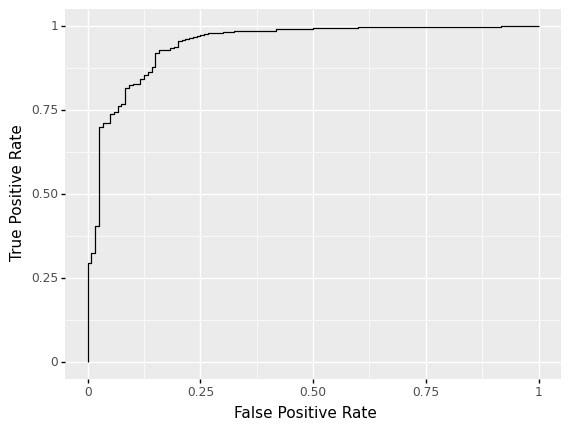

<ggplot: (381123882)>

In [179]:
plot_roc(y_test, y_test_pred_con)

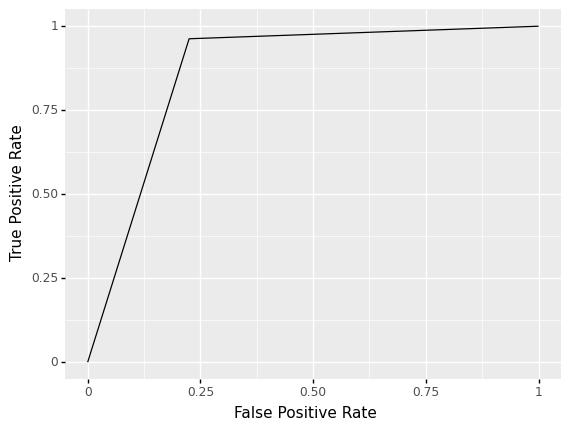

<ggplot: (381353447)>

In [183]:
plot_roc(y_test, y_test_pred_cut)

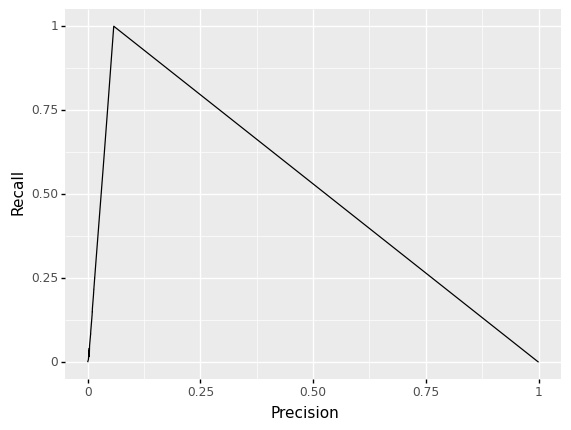

<ggplot: (381625816)>

In [189]:
plot_precision_recall(y_test, y_test_pred_con)